In [1]:
# Import required libraries
from imdclient.IMD import IMDReader
import MDAnalysis as mda

import numpy as np

import matplotlib.pyplot as plt

from IPython.display import display, clear_output

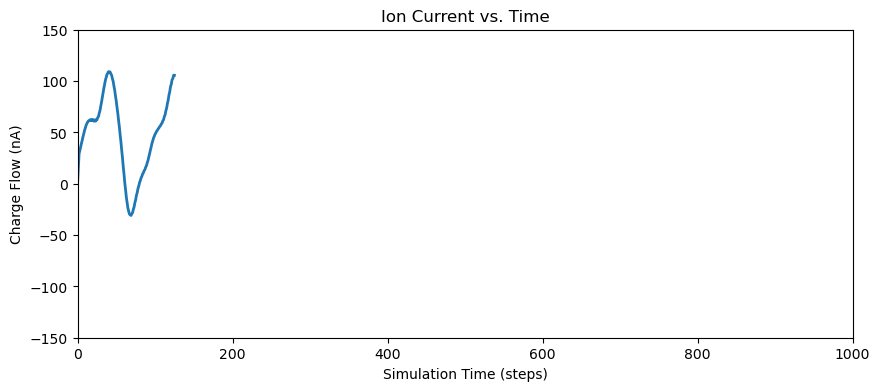

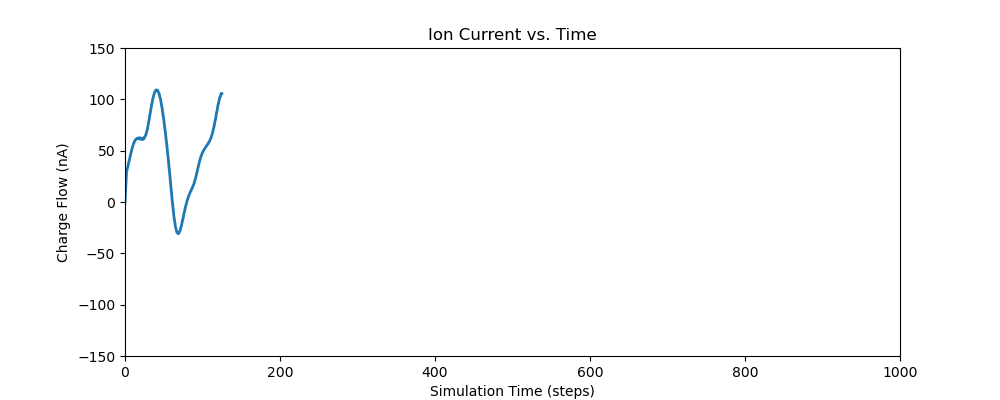

In [ ]:
%matplotlib widget
NAMD_TOPOL = "../exec-files/T3_MNN.psf"

# Initialize MDAnalysis Universe
u = mda.Universe(NAMD_TOPOL, "imd://localhost:1027")

# Enable interactive plotting
plt.ion()

# Initialize the plot
fig, ax = plt.subplots(figsize=(10,6))
line, = ax.plot([], [], lw=2)  # Line for dynamic updates
ax.set_xlim(0, 1000)  # Adjust as necessary
ax.set_ylim(-150, 150)  # Adjust based on expected distance range
ax.set_xlabel("Simulation Time (steps)")
ax.set_ylabel("Charge Flow (nA)")
ax.set_title("Ion Current vs. Time")

# Start the processing thread
x_data = np.zeros(144000) 
y_data = np.zeros(144000)

i = 0

timestep = 2.0 # timestep passed to NAMD in conf file
framediff = 1 # IMDfreq
skip = 1 # if any frames need to be skipped

update_frequency=1
chargeFactor = 1.6022e-19/1.0e-9/1.0e-9   #It's in nanoamps
dt = 1.0*timestep*framediff*skip/1.0e6
#ionText = "name POT CLA CAL SOD LIT CES IOD BRO H11 H21 H31 H41"
ionText = "name POT"
ions = u.select_atoms(ionText)
charge = ions.charges
dims = ions.dimensions
zdist = dims[2]

for t in u.trajectory:
    newPos = ions.positions
    idx = i % 1000

    if i == 0:
        ionPos = newPos
    else:
        deltas = newPos[:,2]-ionPos[:,2]
        deltas[deltas>zdist/2.] = deltas[deltas>zdist/2.] - zdist
        deltas[deltas<-zdist/2.] = deltas[deltas<-zdist/2.] + zdist
        cd = deltas*charge
        tCur = np.sum(cd)/zdist/dt*chargeFactor
        ionPos = newPos
        time = round(dt * i - dt/2, 4)
        x_data[i] = i + 1
        y_data[i] = tCur
    i = i + 1

    valid_indices = range(0, idx + 1)

    # Update the plot periodically
    if i % update_frequency == 0:
        line.set_data(x_data[valid_indices], y_data[valid_indices])  # Efficiently update the line with all data
        # ax.set_xlim(0, max(200,max(x_data)+100))  # Adjust X-axis dynamically
        clear_output(wait=True)
        display(fig)